# Solving the Deterministic Firm Investment Problem Through Value Function Iteration - Using Interpolation
### by [Jason DeBacker](http://jasondebacker.com), November 2017
This Jupyter Notebook extends the basic VFI solution method from a previous notebook to now include interpolation of the value function at each step in the VFI algorithm.  This provoides a better approximation of the value and policy functions over the discrete grid.  But it does come at a cost - increased computational time.


## 1. Overview of the Theory
The firm's optimization problem can be written as:

$$ V(z,k) = max_{k'} \pi(z,k) - p^{k}(k'-(1-\delta)k) - c(k',k) + \beta V(z',k') $$

We going to assume that $z$ is deterministic and stationary.  Thus we'll set $z=1$ for all time and drop it from our vector of state variables.  In addition, assume that the price of new capital is equal to one; $p^{k}=1$.  Rewriting the problem we have:

$$ V(k) = max_{k'} \pi(k) - (k'-(1-\delta)k) - c(k',k) + \beta V(k') \ \ (1) $$ 

We need to solve for $V(k)$ and the policy function, $k'=h(k)$.  To do this, we are going to use the recursive nature of the problem.  In particular, we are going to use a fixed point algorithm and the fact that the value funciton, $V(\cdot)$ appears on both sides of the equation above.

In particular, we are going to look for the fixed point for the mapping $T(V(k))$ defined as 

$$ T(V(k)) = max_{k'} \pi(k) - (k'-(1-\delta)k) - c(k',k) + \beta V(k') $$

Here, $V(k)$ represents a proposed solution to the Equation (1) above.  If $T(V(k))=V(k)$ then $V(k)$ *is* the solution to (1).  Value function iteration uses this mapping to find the solution.  Under certain assumptions, it is shown that such a solution exists, is unique, and can be found by iterating on any initial proposed value function.  See Stokey, Lucas, and Prescott (1989, pp. 49-55) for details on the necessary conditions for the existence and uniqueness of a solution.  Suffice it to say, those conditions are met in the problem as parameterized below.

The approach we'll take, then, is to guess an initial value function, $V_{0}(k)$ and then iterate on this guess with the operators $T(v(k))$ so that we have:

$$ V_{i+1}(k) = max_{k'} \pi(k) - (k'-(1-\delta)k) - c(k',k) + \beta V_{i}(k') $$

Where $i$ denotes the iteration.  These iterations will continue until $V_{i+1}(k)=V_{i}(k)$, i.e., when we've found the fixed point.  This fixed point will be the solution to our problem, $V(k)=V_{i}(k)$.  With this found, we can then find the policy function, $h(k)$ that corresponds to this value function.

## 2. Setting things up.

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# to print plots inline
%matplotlib inline

### 2.1 Parameterization
To solve a numerical problem, we need to set values to the parameters.  We also need to specify the adjustment cost function.  Adjustment costs will be assumed to be quadratic:

$$ c(k',k) = \frac{\psi}{2}\left(\frac{k'-(1-\delta)k}{k}\right)^{2}k $$

Operating profits are given by $zk^{\alpha_{k}}l^{\alpha_{l}} - wl$.  After solving the firm's intra-temporal problem for the optimal choice of $l$ given $k4$, we find

$$ \pi(z,k)=\left(1-\alpha_{l}\right)\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}} z^{\frac{1}{1-\alpha_{l}}}k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

Or, noting that $z=1$ in the deterministic model we're studying here:

$$ \pi(k)=\left(1-\alpha_{l}\right)\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}} k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

We then choose the following parameterization:

| Paramter | Description   | Value|
|------|------||------|
    | $\alpha_{k}$ | Capital's share of output | 0.297 |
   | $\alpha_{l}$ | Labor's share of output | 0.650 |
   | $\delta$ | Depreciation rate | 0.154 |
   | $\psi$ | Coefficient on quadratic adjustment costs | 1.080 |
   | $w$   | Wage rate | 0.700 |
   | $r$   | Interest rate | 0.040 |
   | $z$   | Productivity | 1.000 |



In [2]:
# specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
z = 1

To determine the discount rate of the firm, we have:



In [3]:
betafirm = (1 / (1 + r))

### 2.2 Discretizing the state space for capital

To solve this problem we will be evaluating the value function over a discrete grid of points in the state space.  Our state space are the possible values of the firm's capital stock.  We need to put some thought into how to choose these grid points, since we are approximating the continuous value function over this grid.  

As a starting point, recall the solution to the firm's problem without adjustment costs:

$$ k_{t+1} = \left[\left(\frac{\alpha_{k}}{\bar{r}  + \delta}\right)^{1-\alpha_{l}}\left(\frac{\alpha_{l}}{w}\right)^{\alpha_{l}}z_{t+1}^{\alpha_{l}}\right]^{1-\alpha_{k}-\alpha_{l}} $$

In this case, we are setting $z=1$, so we have:

$$ k_{t+1} = \left[\left(\frac{\alpha_{k}}{\bar{r}  + \delta}\right)^{1-\alpha_{l}}\left(\frac{\alpha_{l}}{w}\right)^{\alpha_{l}}\right]^{1-\alpha_{k}-\alpha_{l}} \ \ \ (2) $$

This value for $k'$ in the model with no adjustment costs is a good place to center the grid as it's close to the steady-state value of the problem with adjustment costs.  In the steady-state, the firm's capital stock does not change and thus with the adjustment cost function specified, only small costs are paid as investment is just enough to offset depreciation.

Next, we need to think about how to space the grid points.  One consideration here is that since we are approximating a value function that is concave, we want to have more grid points in the space where there is more curvature in the function.  That is, we want more grid points on the part of the grid with smaller amounts of capital as the value function will have more curvature in this range since it's a concave function.  Second, there is some convenience in spacing the grid points out so that we know the number of points between the points for $k$ and $(1-\delta)k$ (this will be more apparent when we get to models with other types of adjustment costs).

Given these two considerations, let us define `dens` as the number of grid points between $k$ and $(1-\delta)k$ and then define the sequence of grid points by

$$ k^{i} = (1-\delta)^{\frac{1}{\texttt{dens}}}k^{i+1} $$

We implement this in the code below, setting the lower bound of the capital grid to a small, positive number, the upper bound to a multiple of the $k'$ implied by Equation (2), and then determining the number of grid points between these bounds given our rule for spacing described above.

In [4]:
dens = 5
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kgrid = K[::-1]
sizek = kgrid.shape[0]

Let's look at this grid...

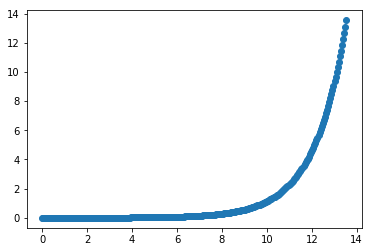

In [5]:
k_linear = np.linspace(lb_k, ub_k, num=sizek)
plt.scatter(k_linear, kgrid)

### 2.3 Grid of per period flows

In order to evaluate our value functions, we will need to know the per period flows to the firm.  These are given by operating profits, $\pi(k)$, less investment expenses plus adjustment costs, $I + c(k',k)$.

As noted above, operating profits (with $z=1$) are given by:

$$
\pi(k) =\left(1-\alpha_{l}\right)\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}}k^{\frac{\alpha_{k}}{1-\alpha_{l}}} 
$$
Per period flows are then:

$$ e(k,k') = \pi(k) - (k'-(1-\delta)k) - \frac{\psi}{2}\left(\frac{k'-(1-\delta)k}{k}\right)^{2}k $$

In [6]:
# operating profits, op
op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((kgrid ** alpha_k) ** (1 / (1 - alpha_l))))

# firm cash flow, e
e = np.zeros((sizek, sizek))
for i in range(sizek):
    for j in range(sizek):
            e[i, j] = (op[i] - kgrid[j] + ((1 - delta) * kgrid[i]) -
                       ((psi / 2) * ((kgrid[j] - ((1 - delta) * kgrid[i])) ** 2)
                        / kgrid[i]))

## 3. Value Function Iteration

We've now determined all the fundamental objects we need to do value function iteration over a discete grid.  There are a few more objects we need to create that determine when convergence has been reached and to ensure that our `while` loops end.  We'll also want to intialize arrays that will be populated in our VFI.  

Note that any initial guess at the value function $V_{0}$ will work.  But closer guesses will mean less iterations until convergence.  Here, we just guess a vector of zeros.  We know it's not the solution, but it gives us a starting point.

In [7]:
VFtol = 1e-6
VFmaxiter = 3000
VFdist = 7.0
V = np.zeros(sizek)  # initial guess at value function
Vmat = np.zeros((sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1

### 3.1 VFI without interpolation
With these objects of the VFI procedure defined, we now write the loop that is the VFI prodecure.  We are iterating over the operator $T(V(k))$, so our outer most loop will represent our updating of the value function $V_{i}(k)$ that happens with each iteration of VFI.  Inside this loop, we need to apply the operator.  We do this by evaluating the finding the optimal choice of $k'$ given $k$ and $V_{i}(k)$.  Note that as we find the optimal choice of $k'$ we'll store both the value function evaluated at this $k'$ and also the value of $k'$ (because these choices define our policy function).

In [8]:
start_time = time.clock()
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            Vmat[i, j] = e[i, j] + betafirm * V[j]
    Vstore[:, VFiter] = V.reshape(sizek,)  # store value function at each
    # iteration for graphing later
    V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')


VF = V  # solution to the functional equation

Value function converged after this many iterations: 310
VFI took  18.914608  seconds to solve


### 3.2 VFI with interpolation

To interpolate the value function at each iteration of the  VFI solution method, it'll be helpful to define a few functions that we can call during the solution method.  Let's define functions for operating profits, adjustment costs, and firm cash flows.

In [9]:
def op_profits(k, params):
    """
    Operating profits function
    """
    alpha_l, alpha_k, w = params
    op = ((1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
      ((k ** alpha_k) ** (1 / (1 - alpha_l))))
    
    return op

            
def adj_cost(k, kprime, params):
    """
    Adjustment cost function
    """
    psi, delta = params
    cost = (psi / 2) * ((kprime - (1 - delta) * k) ** 2) / k
    
    return cost


def cash_flow(k, kprime, params):
    """
    Cash flow function
    """
    alpha_l, alpha_k, w, psi, delta = params
    op_params = (alpha_l, alpha_k, w)
    cost_params = (psi, delta)
    e = op_profits(k, op_params) - kprime + (1 - delta) * k - adj_cost(k, kprime, cost_params)
    
    return e

Next, we'll define a function for the Bellman operator itself: $V_{i+1} = T(V_{i})$.  We are using a funciton for this now since we are doing more than just applyin the $max$ operator at each step, we are now interpolating the value function and choosing the optimal $k'$ using the interpolation of $V(k')$.  

In [10]:
# write Bellman operator function to help with VFI
from scipy.optimize import fminbound

def bellman_operator(V, kgrid, params):
    """
    The approximate Bellman operator, which computes and returns the
    updated value function TV on the grid points.  An array to store
    the new set of values TV is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.
    """
    betafirm, alpha_l, alpha_k, w, psi, delta = params
    e_params = (alpha_l, alpha_k, w, psi, delta)
    
    # Apply linear interpolation to V
    V_func = lambda x: np.interp(x, kgrid, V)

    # Initialize array for operator and policy function
    TV = np.empty_like(V)
    optK = np.empty_like(TV)

    # == set TV[i] = max_k' { e(k,k') + beta V(k')} == #
    for i, k in enumerate(kgrid):
        def objective(kprime):
            return - cash_flow(k, kprime, e_params) - betafirm * V_func(kprime)
        kprime_star = fminbound(objective, 1e-10, kgrid[-1])
        optK[i] = kprime_star
        TV[i] = - objective(kprime_star)

    return TV, optK

Finally, we'll write our VFI "while" loop.  This loop will call the Bellman operator at each iteration until convergence.

In [11]:
# Reset distance, etc
VFdist = 7.0
V = np.zeros(sizek)  # initial guess at value function
Vmat = np.zeros((sizek, sizek))  # initialize Vmat matrix
Vstore = np.zeros((sizek, VFmaxiter))  # initialize Vstore array
VFiter = 1

# Now solve VFI using bellman operator function (and thus interpolation)
V_params = (betafirm, alpha_l, alpha_k, w, psi, delta)
start_time = time.clock()
while VFdist > VFtol and VFiter < VFmaxiter:
    Vstore[:, VFiter] = V
    TV, optK = bellman_operator(V, kgrid, V_params)
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    V = TV
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')


VF = V  # solution to the functional equation

Value function converged after this many iterations: 310
VFI took  61.52063  seconds to solve


We can then plot our solution:

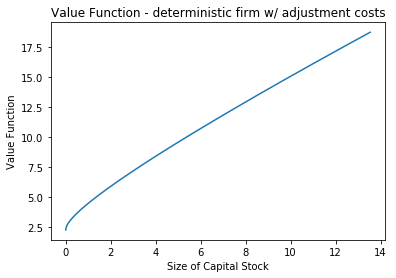

In [12]:
plt.plot(kgrid, VF)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')

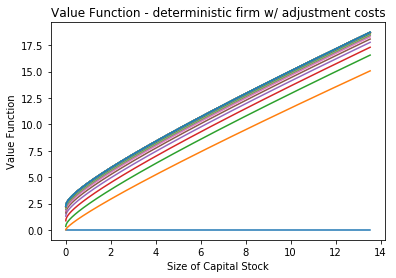

In [13]:
# Plot VFI at as converges
for i in range(VFiter):
    if i%10 == 0:
        plt.plot(kgrid, Vstore[:, i])
        
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')

## 4. Determining the policy functions

We've already done the work to recover our policy functions, since we saved them along the way in our VFI loop.  From here, it's straight forward to get the policy functions.  Note that with the interpolation we don't have to choose a $k'$ that lies on the `kgrid`.  So we have `optK`, but now `PF` object that gives us the index of the optimal $k$.  This will be all we need anyway.

In [16]:
'''
------------------------------------------------------------------------
Find optimal capital and investment policy functions
------------------------------------------------------------------------
optK = (sizek,) vector, optimal choice of k' for each k
optI = (sizek,) vector, optimal choice of investment for each k
------------------------------------------------------------------------
'''
optI = optK - (1 - delta) * kgrid

## 5. Check output!

Congratulations!  You solved the model and determined the optimal firm value, $V(k)$ and the it's optimal choice of investment, $h(k)$.  Now let's look over the output to be sure this makes sense.

## 5.1 Plotting the value function.

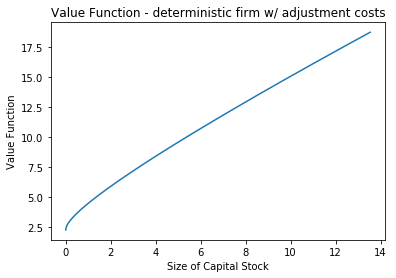

In [50]:
plt.plot(kgrid, VF)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic firm w/ adjustment costs')

## 5.2 Plot the policy functions

Here we'll plot investment policy function as a rate, $\frac{I}{k}$.

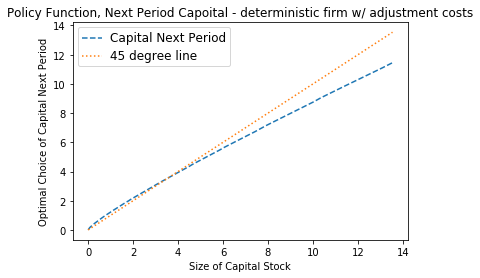

In [14]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots()
ax.plot(kgrid, optK, '--', label='Capital Next Period')
ax.plot(kgrid, kgrid, ':', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

NameError: name 'optI' is not defined

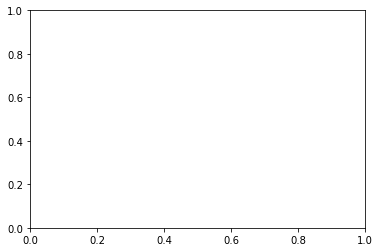

In [15]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots()
ax.plot(kgrid, (optI/kgrid), '--', label='Investment rate')
ax.plot(kgrid, (np.ones(sizek)*delta), ':', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - deterministic firm w/ adjustment ' +
          'costs')

## 7. References
* Stokey, Nancy L. and Robert E. Lucas and Edward C. Prescott, *Recursive Methods in Economic Dynamics*, Harvard University Press (1989).